<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Predicting_Sunspots_with_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [24]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Download and Preview the Dataset

In [25]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-04-25 17:05:22--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.207, 142.250.152.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv.1’

Sunspots.csv.1      100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-04-25 17:05:22 (109 MB/s) - ‘Sunspots.csv.1’ saved [70827/70827]



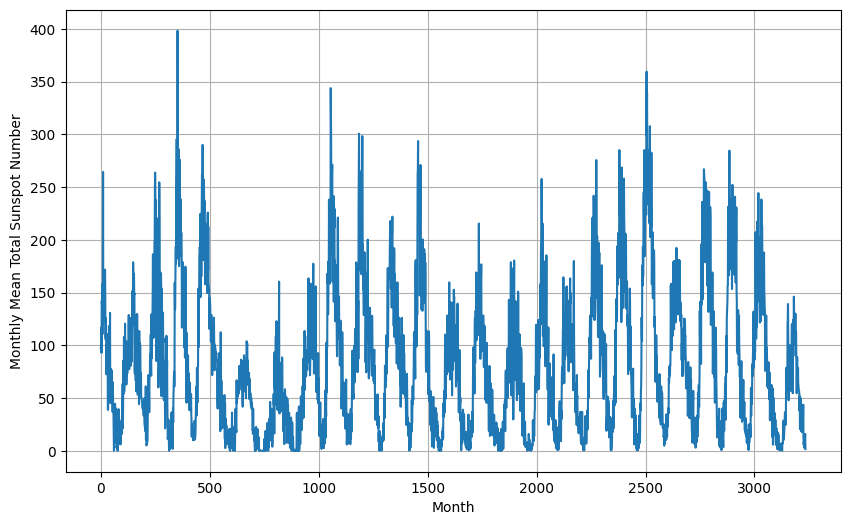

In [26]:
# Initialize lists
time_step = []
sunspots = []

# Open csv file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile,delimiter = ',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy array
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

# Split the Dataset

In [27]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare features and labels

In [28]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1,shift = 1,drop_remainder = True)

  dataset = dataset.flat_map(lambda w : w.batch(window_size + 1))

  dataset = dataset.map(lambda w : (w[:-1],w[-1]))

  dataset = dataset.shuffle(shuffle_buffer)

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [29]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset window
train_set = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

# Build the model

In [30]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters = 64,
        kernel_size = 3,
        activation = 'relu',
        padding = 'causal',
        strides = 1,
        input_shape = [window_size,1]
    ),
    tf.keras.layers.LSTM(64,return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30,activation = 'relu'),
    tf.keras.layers.Dense(10,activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

# Tune the learning rate

In [31]:
init_weights = model.get_weights()

In [32]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * (10 ** (epoch/20))
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the model parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
)

# Train the model
history = model.fit(
    train_set,
    epochs = 100,
    callbacks = [lr_schedule]
)

Epoch 1/100
93/93 [==============================] - 9s 53ms/step - loss: 60.1340 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 4s 41ms/step - loss: 46.3773 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 5s 48ms/step - loss: 39.7736 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 4s 39ms/step - loss: 34.6698 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 5s 49ms/step - loss: 30.4030 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 4s 38ms/step - loss: 27.9842 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 39ms/step - loss: 26.5754 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 5s 48ms/step - loss: 25.4911 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 39ms/step - loss: 24.2022 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 4s 39ms/step - loss: 23.3085 - lr: 2.8184e-08
Epoch 11/

In [ ]:
# Define the learning rate decay
lrs = 1e-8 * (10 ** np.arange(100)/20)

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs,history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Train the model

In [37]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [38]:
# Set the learning rate scheduler
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate = learning_rate,
    momentum = 0.9
)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

In [ ]:
# Train the model
history = model.fit(
    train_set,
    epochs = 100
)

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Model Prediction